In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.layers import Embedding, SimpleRNN, Dense, Flatten
from keras import Sequential

2023-12-12 00:10:33.443872: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 00:10:33.588065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 00:10:33.588089: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 00:10:33.588957: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 00:10:33.650306: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 00:10:33.651380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Данные из архива погоды. Санкт-Петербург

In [2]:
df = pd.read_csv('data.csv', sep=';')
print(df.head())
series_analise =  df['Максимальная  температура'] 
series_analise_date = df['Дата']


         Дата  Максимальная  температура  Минимальная  температура  \
0  07.12.1990                        3.7                      -4.5   
1  08.12.1990                        3.4                       0.9   
2  09.12.1990                        0.6                      -0.8   
3  10.12.1990                       -0.4                      -3.7   
4  11.12.1990                       -1.6                      -4.1   

   Средняя  температура  Атмосферное  давление  Скорость  ветра  Осадки  \
0                   1.2                 1008.0                5     0.0   
1                   2.3                 1016.1                3     3.0   
2                  -0.3                 1023.5                1     1.0   
3                  -2.7                 1023.7                2     0.0   
4                  -2.9                 1015.4                3     1.0   

   Эффективная  температура  
0                      -3.5  
1                      -1.0  
2                      -2.6  
3       

# Вычисление среднего за определенное количество периодов

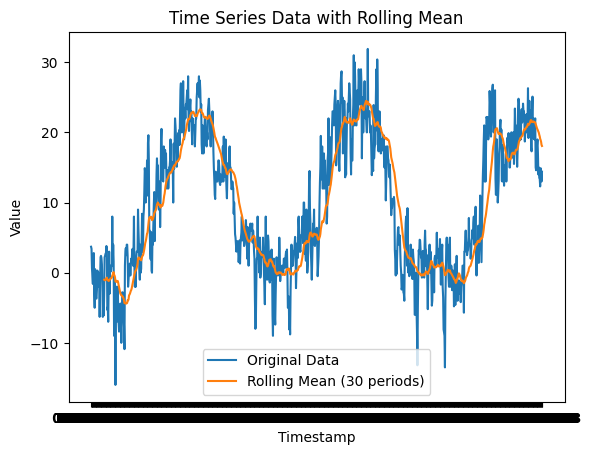

In [82]:

window_size = 30  # количество прошлых периодов
rolling_mean = series_analise.rolling(window=window_size).mean()

plt.plot(series_analise_date, series_analise, label='Original Data')
plt.plot(series_analise_date, rolling_mean, label=f'Rolling Mean ({window_size} periods)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series Data with Rolling Mean')
plt.legend()
plt.show()


# Linear 

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np 

feature = pd.to_datetime(series_analise_date, format='%d.%m.%Y').astype(int) // 10**9 # переводим в секунды

X_train, X_test, y_train, y_test = train_test_split(np.array(feature).reshape(-1, 1), series_analise, test_size=0.2, random_state=42)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()  

model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('R^2:', r2_score(y_test, predictions))



MAE: 8.876456840334942
MSE: 102.27280524189395
R^2: 0.028116460166498825


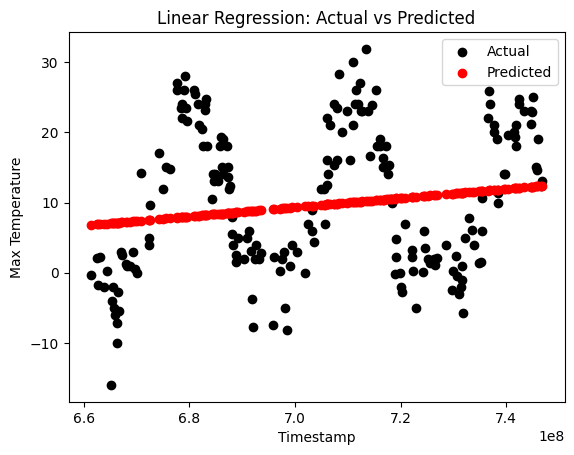

In [6]:
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.scatter(X_test, predictions, color='red', label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Max Temperature')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()  

model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('R^2:', r2_score(y_test, predictions))




MAE: 2.1928899999999993
MSE: 8.2474884
R^2: 0.9216253215899439


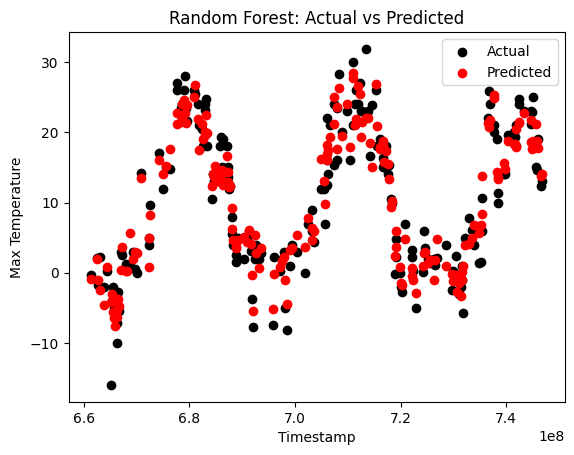

In [8]:
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.scatter(X_test, predictions, color='red', label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Max Temperature')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.show()

# MLP

In [87]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor( max_iter=100, random_state=37)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('R^2:', r2_score(y_test, predictions))


MAE: 0.1720467310244773
MSE: 0.04083743175974788
R^2: 0.03959655234859527


/home/andrew/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


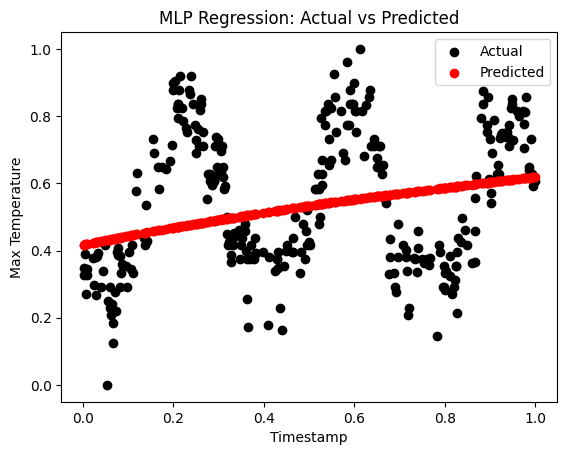

In [88]:
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.scatter(X_test, predictions, color='red', label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Max Temperature')
plt.title('MLP Regression: Actual vs Predicted')
plt.legend()
plt.show()

# LSTM

In [72]:
from sklearn.preprocessing import MinMaxScaler
from keras.src.layers import  LSTM, GRU

X = feature.values.reshape(-1, 1)
y = series_analise.values.reshape(-1, 1)

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Функция для преобразования данных в формат, подходящий для LSTM
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        v = X[i:(i + time_steps), 0]
        Xs.append(v)
        ys.append(y[i + time_steps - 1, 0])
    return np.array(Xs), np.array(ys)

time_steps = 250
n_features = 1  # количество признаков


X_train_lstm, y_train_lstm = create_dataset(X_train, y_train, time_steps)
print(X_train_lstm.shape, y_train_lstm.shape)
print(X_test.shape, y_test.shape)
X_test_lstm, y_test_lstm = create_dataset(X_test, y_test, time_steps)
print(X_test_lstm.shape, y_test_lstm.shape)



(451, 250) (451,)
(300, 1) (300, 1)
(51, 250) (51,)


In [73]:

model = Sequential()
model.add(LSTM(units=800, input_shape=(time_steps, n_features)))
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_lstm, y_train_lstm, epochs=15, verbose=1)


Epoch 1/15
15/15 [==============================] - 12s 752ms/step - loss: 0.0415
Epoch 2/15
15/15 [==============================] - 11s 752ms/step - loss: 0.0399
Epoch 3/15
15/15 [==============================] - 11s 756ms/step - loss: 0.0400
Epoch 4/15
15/15 [==============================] - 11s 746ms/step - loss: 0.0402
Epoch 5/15
15/15 [==============================] - 11s 748ms/step - loss: 0.0399
Epoch 6/15
15/15 [==============================] - 11s 749ms/step - loss: 0.0398
Epoch 7/15
15/15 [==============================] - 11s 747ms/step - loss: 0.0397
Epoch 8/15
15/15 [==============================] - 11s 751ms/step - loss: 0.0397
Epoch 9/15
15/15 [==============================] - 11s 765ms/step - loss: 0.0397
Epoch 10/15
15/15 [==============================] - 11s 754ms/step - loss: 0.0398
Epoch 11/15
15/15 [==============================] - 11s 749ms/step - loss: 0.0396
Epoch 12/15
15/15 [==============================] - 11s 755ms/step - loss: 0.0399
Epoch 13/15
1

In [74]:
predictions_scaled = model.predict(X_test_lstm)
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

print('MAE:', mean_absolute_error(y_test_inv, predictions))
print('MSE:', mean_squared_error(y_test_inv, predictions))
print('R^2:', r2_score(y_test_inv, predictions))

2/2 [==============================] - 1s 85ms/step
MAE: 8.229853480469947
MSE: 86.61098873311543
R^2: 0.0061497489475931255


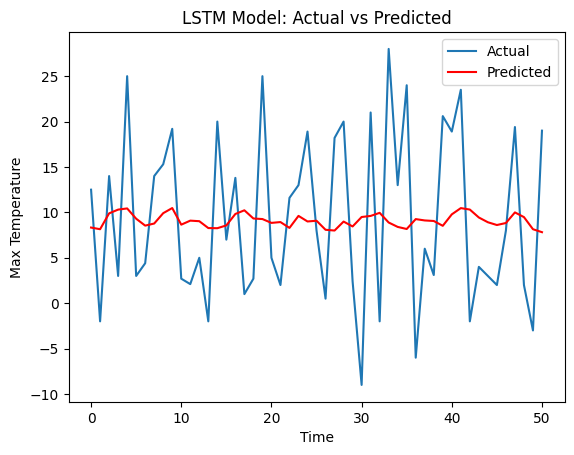

In [75]:


plt.plot(y_test_inv, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Max Temperature')
plt.title('LSTM Model: Actual vs Predicted')
plt.legend()
plt.show()

